In [1]:
# !pip3 install tensorflow==2.8.0

In [1]:
import tensorflow as tf

In [2]:
print(tf.__version__)

2.8.0


In [3]:
tf.config.list_physical_devices('GPU')[0]

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

In [4]:
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

In [5]:
import tensorflow_hub as hub

## Getting the data

* PubMed 200k RCT

In [9]:
# !git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls 'pubmed-rct'

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [10]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [12]:
import os
filenames = [data_dir + "/" + filename for filename in os.listdir("pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign")]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

In [13]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [14]:
train_lines = get_lines(filenames[2])
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [15]:
len(train_lines)

210040

In [16]:
val_lines = get_lines(filenames[0])
test_lines = get_lines(filenames[1])

```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': 'Emotional eating is associated with overeating and the development of obesity .\n'
   'total_lines': 11},
   ...]
```

In [17]:
def preprocess_text_with_line_numbers(filename):
  """
  Return a list of dictionaries of abstract line data.
  """
  input_lines = get_lines(filename) # get all lunes from filename
  absctract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if its the ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line

    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate line

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) -1
        abstract_samples.append(line_data)

    else:
        abstract_lines += line

  return abstract_samples

In [19]:
# Get data from file and preprocess it
# %%time
train_samples = preprocess_text_with_line_numbers(filenames[2])
val_samples = preprocess_text_with_line_numbers(filenames[0])
test_samples = preprocess_text_with_line_numbers(filenames[1])
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [20]:
train_samples[:12]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [21]:
import pandas as pd

In [22]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [23]:
train_df.head(20)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [24]:
train_df["target"].value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

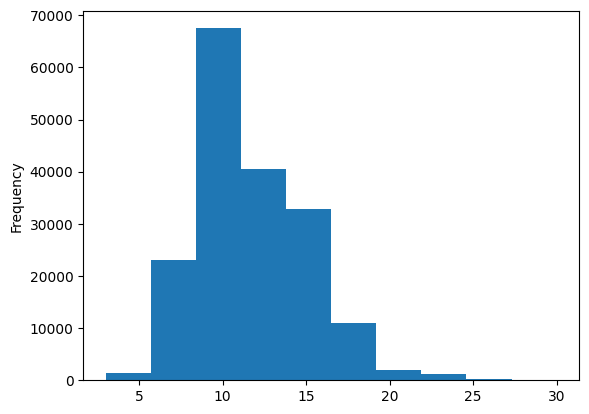

In [25]:
train_df["total_lines"].plot.hist()

## Get lists of sentences

In [26]:
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [27]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels

In [28]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))

C:\Users\yihim\anaconda3\envs\mldl\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [29]:
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [30]:
# label encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [31]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

## Get the target names

In [32]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Baseline

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfid", TfidfVectorizer()),
    ("cld", MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tfid', TfidfVectorizer()), ('cld', MultinomialNB())])

In [34]:
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [35]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [36]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [37]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns

def model_evaluation_metrics(y_true, y_preds):
  results = {}
  pre, rec, f1, _ = precision_recall_fscore_support(y_true, y_preds, average="weighted")
  results["Accuracy"] = accuracy_score(y_true, y_preds)
  results["Precision"] = pre
  results["Recall"] = rec
  results["f1-score"] = f1
  return results

In [38]:
baseline_results = model_evaluation_metrics(y_true=val_labels_encoded, y_preds=baseline_preds)
baseline_results

{'Accuracy': 0.7218323844829869,
 'Precision': 0.7186466952323352,
 'Recall': 0.7218323844829869,
 'f1-score': 0.6989250353450294}

## Model 1: Conv1D with token embedding

In [39]:
from tensorflow.keras.layers import TextVectorization, Embedding
import numpy as np

In [40]:
# How long is each sentence on average ?
avg_sent_len = sum([len(sentence.split()) for sentence in train_sentences])/len(train_sentences)

In [41]:
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

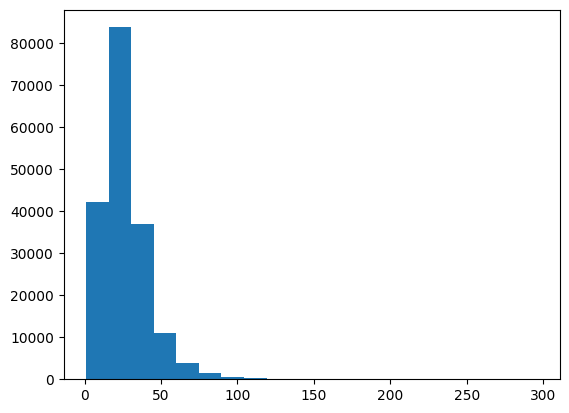

In [42]:
import matplotlib.pyplot as plt
plt.hist([len(sentence.split()) for sentence in train_sentences], bins=20)

In [43]:
# How long of a sentence length covers 95% of the samples ?
output_seq_len = int(np.percentile([len(sentence.split()) for sentence in train_sentences], 95))
output_seq_len

55

In [44]:
max([len(sentence.split()) for sentence in train_sentences])

296

In [45]:
max_vocab_size = 68000
text_vectorizer = TextVectorization(max_tokens=max_vocab_size,
                                    output_sequence_length=output_seq_len,
                                    output_mode="int")

In [46]:
text_vectorizer.adapt(train_sentences)

In [47]:
text_vectorizer.vocabulary_size()

64841

In [48]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}\n")
print(f"Length of text: {len(target_sentence.split())}\n")
print(f"Vectorized text: {text_vectorizer([target_sentence])}")

Text:
prior studies adjusting self-reported measures of alcohol intake for drink size and ethanol ( etoh ) content have relied on single-point assessments .

Length of text: 23

Vectorized text: [[  452   202  1515   799   213     4   461   399    11  2244   375     3
   3531 10364  1014    99 13737    18 45463   657     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [49]:
vocabalary = text_vectorizer.get_vocabulary()

In [50]:
len(vocabalary)

64841

In [51]:
vocabalary[:10]

['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']

In [52]:
vocabalary[-10:]

['aarm',
 'aaqol',
 'aaq',
 'aanhui',
 'aana',
 'aainduced',
 'aaigroup',
 'aachener',
 'aachen',
 'aaacp']

In [53]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [54]:
token_embed = Embedding(input_dim=len(vocabalary),
                        output_dim=128,
                        input_length=output_seq_len,
                        mask_zero=True,
                        name="token_embedding")

In [55]:
print(f"Sentence before vectorization:\n{target_sentence}\n")
print(f"Sentence after vectorization:\n{text_vectorizer([target_sentence])}\n")
print(f"Sentence after vectorization shape:\n{text_vectorizer([target_sentence]).shape}\n")
print(f"Embedding with masking zero:\n{token_embed(text_vectorizer([target_sentence]))}\n")
print(f"Embedding shape:\n{token_embed(text_vectorizer([target_sentence])).shape}\n")

Sentence before vectorization:
prior studies adjusting self-reported measures of alcohol intake for drink size and ethanol ( etoh ) content have relied on single-point assessments .

Sentence after vectorization:
[[  452   202  1515   799   213     4   461   399    11  2244   375     3
   3531 10364  1014    99 13737    18 45463   657     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after vectorization shape:
(1, 55)

Embedding with masking zero:
[[[ 0.00349252  0.04418749  0.0019707  ... -0.0176341   0.0007522
    0.03568797]
  [-0.0304403   0.03988066 -0.01936331 ... -0.00284885  0.01096997
   -0.04786394]
  [ 0.04252445  0.00632143  0.03624294 ...  0.01884295  0.00798404
    0.01848098]
  ...
  [-0.00010793  0.00082121  0.04784396 ...  0.03796575  0.04726887
   -0.02557969]
  [-0.00010793  0.00082121  0.047

In [56]:
def create_tensor_dataset(X, y):
  return tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [57]:
train_dataset = create_tensor_dataset(X=train_sentences, y=train_labels_one_hot)
valid_dataset = create_tensor_dataset(X=val_sentences, y=val_labels_one_hot)
test_dataset = create_tensor_dataset(X=test_sentences, y=test_labels_one_hot)

In [58]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [59]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(64, 5, padding="same", activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

In [60]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [61]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [62]:
model_1_history = model_1.fit(train_dataset,
                              validation_data=valid_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_steps=int(0.1 * len(valid_dataset)),
                              epochs=3)

Epoch 1/3
562/562 [==============================] - 15s 13ms/step - loss: 0.9148 - accuracy: 0.6381 - val_loss: 0.6825 - val_accuracy: 0.7387
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6543 - accuracy: 0.7589 - val_loss: 0.6340 - val_accuracy: 0.7713
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6145 - accuracy: 0.7753 - val_loss: 0.5949 - val_accuracy: 0.7872


In [63]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5949 - accuracy: 0.7885


[0.5949124097824097, 0.7885277271270752]

In [64]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[4.7640353e-01, 1.5101318e-01, 5.8894616e-02, 2.8891337e-01,
        2.4775276e-02],
       [3.9569217e-01, 3.3984730e-01, 1.2580516e-02, 2.4161062e-01,
        1.0269435e-02],
       [1.4837055e-01, 6.6102338e-03, 1.6642211e-03, 8.4332627e-01,
        2.8696068e-05],
       ...,
       [1.1862968e-05, 8.6803996e-04, 8.9318445e-04, 7.0527208e-06,
        9.9821979e-01],
       [4.3432847e-02, 4.5163506e-01, 9.3876354e-02, 4.6269260e-02,
        3.6478648e-01],
       [1.4402403e-01, 7.2653008e-01, 4.6418395e-02, 4.2808678e-02,
        4.0218797e-02]], dtype=float32)

In [65]:
model_1_pred_probs.shape

(30212, 5)

In [66]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [67]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [68]:
model_1_results = model_evaluation_metrics(val_labels_encoded,
                                           model_1_preds)
model_1_results

{'Accuracy': 0.788527737322918,
 'Precision': 0.7859343922179475,
 'Recall': 0.788527737322918,
 'f1-score': 0.7864668765893221}

## Model 2: TensorFlow Hub Pretrained Feature Extractor

In [69]:
import tensorflow_hub as hub

In [70]:
tf_hub_embedding_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [71]:
# Test out the pretrained embedding on a random sentence
random_sentence = random.choice(train_sentences)
print(f"Random sentence: {random_sentence}\n")
print(f"Embedded: {tf_hub_embedding_layer([random_sentence])}\n")
print(f"Embedded shape: {tf_hub_embedding_layer([random_sentence]).shape}\n")

Random sentence: the davunetide and placebo groups did not differ in the change from baseline in psprs ( median @ -lsb- @ % ci @ to @ -rsb- vs @ -lsb- @ to @ -rsb- , respectively , p = @ ) or seadl ( -@ -lsb- -@ to -@ -rsb- vs -@ -lsb- -@ to -@ -rsb- , respectively , p = @ ) .

Embedded: [[-0.03095305 -0.076246   -0.03838537 -0.06829777  0.04361402 -0.06665874
  -0.00058512 -0.04531023 -0.05052149  0.07069986  0.0399209  -0.04857618
   0.02328208  0.0513426   0.03956111  0.04164748 -0.06373548 -0.03578052
   0.04661255 -0.0523167   0.07724126  0.00714873 -0.00898258 -0.01655172
   0.02296347  0.0212946   0.05412969  0.06468442 -0.01050705 -0.00645795
   0.03480773  0.06627116 -0.00882016  0.0156003  -0.03513832  0.04864448
   0.05376981  0.02790495 -0.01981813 -0.03689225  0.06025481  0.05569817
   0.0020547  -0.04328506  0.06388196 -0.0147876   0.01183379 -0.03165405
  -0.0254566  -0.00302624 -0.05068223 -0.03154301 -0.05879248 -0.07435116
   0.0628856   0.04231813 -0.04285903  0.0004

In [72]:
inputs = layers.Input(shape=[], dtype=tf.string)
x = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(5, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs)

In [73]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [74]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [75]:
model_2_history = model_2.fit(train_dataset,
                              validation_data=valid_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_steps=int(0.1 * len(valid_dataset)),
                              epochs=3)

Epoch 1/3
562/562 [==============================] - 13s 19ms/step - loss: 0.9222 - accuracy: 0.6481 - val_loss: 0.7980 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 10s 19ms/step - loss: 0.7681 - accuracy: 0.7016 - val_loss: 0.7555 - val_accuracy: 0.7035
Epoch 3/3
562/562 [==============================] - 11s 19ms/step - loss: 0.7513 - accuracy: 0.7131 - val_loss: 0.7392 - val_accuracy: 0.7111


In [76]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 15s 16ms/step - loss: 0.7408 - accuracy: 0.7139


[0.7407790422439575, 0.7138885259628296]

In [77]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.4206852e-01, 3.7507769e-01, 1.8276911e-03, 1.7363948e-01,
        7.3866379e-03],
       [3.8706669e-01, 4.4700384e-01, 3.3397879e-03, 1.5991847e-01,
        2.6712227e-03],
       [2.3171507e-01, 1.5781838e-01, 1.4500990e-02, 5.5768591e-01,
        3.8279660e-02],
       ...,
       [1.7028049e-03, 5.5181007e-03, 5.0117072e-02, 8.1995863e-04,
        9.4184208e-01],
       [4.4737542e-03, 4.2949338e-02, 2.1861598e-01, 1.7624388e-03,
        7.3219854e-01],
       [1.9544856e-01, 2.9285908e-01, 4.4861582e-01, 7.6692151e-03,
        5.5407327e-02]], dtype=float32)

In [78]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_results = model_evaluation_metrics(val_labels_encoded,
                                           model_2_preds)
model_2_results

{'Accuracy': 0.7138885211174367,
 'Precision': 0.713708110075478,
 'Recall': 0.7138885211174367,
 'f1-score': 0.710812077771951}

## Model 3: Conv1D with character embeddings

### Creating a character-level tokenizer

In [79]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [80]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [81]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [82]:
# Text splitting non-character-level sequence into characters
split_chars(random_sentence)

't h e   d a v u n e t i d e   a n d   p l a c e b o   g r o u p s   d i d   n o t   d i f f e r   i n   t h e   c h a n g e   f r o m   b a s e l i n e   i n   p s p r s   (   m e d i a n   @   - l s b -   @   %   c i   @   t o   @   - r s b -   v s   @   - l s b -   @   t o   @   - r s b -   ,   r e s p e c t i v e l y   ,   p   =   @   )   o r   s e a d l   (   - @   - l s b -   - @   t o   - @   - r s b -   v s   - @   - l s b -   - @   t o   - @   - r s b -   ,   r e s p e c t i v e l y   ,   p   =   @   )   .'

In [83]:
train_chars = [split_chars(sentence) for sentence in train_sentences]

In [84]:
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [85]:
# What is the average character length
char_len = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_len)
mean_char_len

149.3662574983337

In [86]:
train_chars[1], len(train_chars[1]), len(train_chars[1].split())

('a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 273,
 111)

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

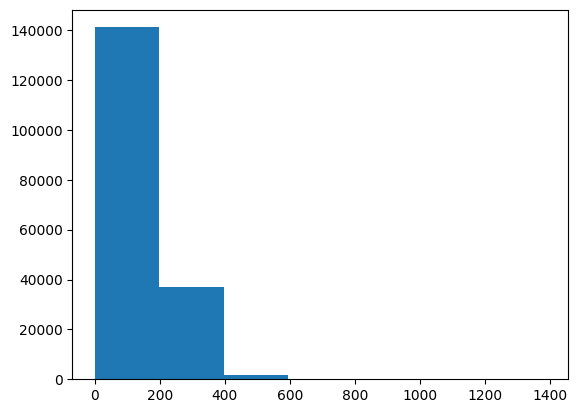

In [87]:
plt.hist(char_len, bins=7)

In [88]:
output_seq_char_len = int(np.percentile(char_len, 95))

In [89]:
output_seq_char_len

290

In [90]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [91]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV (out of vocab = ['UNK']) token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [92]:
NUM_CHAR_TOKENS

70

In [93]:
char_vectorizer.adapt(train_chars)

In [94]:
char_vocab = char_vectorizer.get_vocabulary()

In [95]:
len(char_vocab)

28

In [96]:
char_vocab[:5]

['', '[UNK]', 'e', 't', 'i']

In [97]:
char_vocab[-5:]

['k', 'x', 'z', 'q', 'j']

In [98]:
# Test out the character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Random train chars:\n{random_train_chars}\n")
print(f"Vectorized chars:\n{char_vectorizer([random_train_chars])}\n")
print(f"Vectorized chars shape:\n{char_vectorizer([random_train_chars]).shape}\n")

Random train chars:
p l a s m a   n i t r a t e   i n c r e a s e d   f r o m   @   @   t o   @   @   m   (   a c u t e   )   a n d   @   @   m   (   c h r o n i c   )   a f t e r   b r   s u p p l e m e n t a t i o n   .

Vectorized chars:
[[14 12  5  9 15  5  6  4  3  8  5  3  2  4  6 11  8  2  5  9  2 10 17  8
   7 15  3  7 15  5 11 16  3  2  5  6 10 15 11 13  8  7  6  4 11  5 17  3
   2  8 22  8  9 16 14 14 12  2 15  2  6  3  5  3  4  7  6  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0

In [99]:
char_embedding = Embedding(input_dim=NUM_CHAR_TOKENS,
                           output_dim=25,
                           mask_zero=True,
                           name="char_embed")

In [100]:
print(f"Charified text:\n{random_train_chars}\n")
char_embed_example = char_embedding(char_vectorizer([random_train_chars]))
print(f"Embedded chars:\n{char_embed_example}\n")
print(f"Embedded chars shpae:\n{char_embed_example.shape}\n")

Charified text:
p l a s m a   n i t r a t e   i n c r e a s e d   f r o m   @   @   t o   @   @   m   (   a c u t e   )   a n d   @   @   m   (   c h r o n i c   )   a f t e r   b r   s u p p l e m e n t a t i o n   .

Embedded chars:
[[[-0.00182209  0.04608785 -0.01880499 ...  0.03636576  0.01190628
    0.01047869]
  [ 0.03730759 -0.01076751 -0.01635151 ...  0.04056353 -0.03774755
    0.04383221]
  [-0.00806471 -0.02026157 -0.01043898 ...  0.02185177 -0.01428711
    0.03561968]
  ...
  [ 0.03692684  0.04423013 -0.02433294 ... -0.03195297 -0.04666797
    0.04038895]
  [ 0.03692684  0.04423013 -0.02433294 ... -0.03195297 -0.04666797
    0.04038895]
  [ 0.03692684  0.04423013 -0.02433294 ... -0.03195297 -0.04666797
    0.04038895]]]

Embedded chars shpae:
(1, 290, 25)



In [101]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embedding(x)
x = layers.Conv1D(64, 5, activation="relu", padding="same")(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs)

In [102]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [103]:
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [104]:
train_char_dataset = create_tensor_dataset(train_chars, train_labels_one_hot)
valid_char_dataset = create_tensor_dataset(val_chars, val_labels_one_hot)
test_char_dataset = create_tensor_dataset(test_chars, test_labels_one_hot)

In [105]:
model_3_history = model_3.fit(train_char_dataset,
                              validation_data=valid_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              validation_steps=int(0.1 * len(valid_char_dataset)),
                              epochs=3)

Epoch 1/3
562/562 [==============================] - 6s 8ms/step - loss: 1.2527 - accuracy: 0.4834 - val_loss: 1.0342 - val_accuracy: 0.5904
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.9973 - accuracy: 0.6037 - val_loss: 0.9337 - val_accuracy: 0.6217
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.9044 - accuracy: 0.6444 - val_loss: 0.8552 - val_accuracy: 0.6682


In [106]:
model_3.evaluate(valid_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.8676 - accuracy: 0.6623


[0.8675864338874817, 0.6623196005821228]

In [107]:
model_3_pred_probs = model_3.predict(valid_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 1, 3, 2, 2, 2, 2, 1, 4, 2], dtype=int64)>

In [108]:
model_3_results = model_evaluation_metrics(val_labels_encoded, model_3_preds)
model_3_results

{'Accuracy': 0.6623196081027406,
 'Precision': 0.6577862849357532,
 'Recall': 0.6623196081027406,
 'f1-score': 0.6542609126750079}

## Model 4: Pretrained token embeddings + character embeddings

In [109]:
# Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input") # using shape=[] is because we are using a pretrained model from hub
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# Concatenante token and char inputs - hybrid token embedding
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

# Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation="softmax")(final_dropout)

# Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input], outputs=output_layer)


In [110]:
model_4.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_input[0][0]']      

In [111]:
from tensorflow.keras.utils import plot_model

In [112]:
plot_model(model_4, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [113]:
# Compile
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [114]:
# Combining token and char data
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels))

train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [115]:
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_labels))

val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [116]:
train_token_char_dataset, val_token_char_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [117]:
model_4_history = model_4.fit(train_token_char_dataset,
                              validation_data=val_token_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_token_char_dataset)),
                              validation_steps=int(0.1 * len(val_token_char_dataset)),
                              epochs=3)

Epoch 1/3
562/562 [==============================] - 68s 104ms/step - loss: 0.9856 - accuracy: 0.6068 - val_loss: 0.7835 - val_accuracy: 0.6935
Epoch 2/3
562/562 [==============================] - 56s 99ms/step - loss: 0.8020 - accuracy: 0.6887 - val_loss: 0.7149 - val_accuracy: 0.7281
Epoch 3/3
562/562 [==============================] - 52s 92ms/step - loss: 0.7743 - accuracy: 0.7033 - val_loss: 0.6927 - val_accuracy: 0.7420


In [118]:
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 39s 41ms/step - loss: 0.6983 - accuracy: 0.7374


[0.6982585191726685, 0.7374222278594971]

In [119]:
model_4_pred_probs = model_4.predict(val_token_char_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)
model_4_results = model_evaluation_metrics(val_labels_encoded, model_4_preds)
model_4_results

{'Accuracy': 0.737422216337879,
 'Precision': 0.7374992210905073,
 'Recall': 0.737422216337879,
 'f1-score': 0.7352409727832856}

## Model 5: Pretrained token embedding + character embedding + positional embedding

In [120]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


Any engineered features used to train a model need to be available at test time, in this case, line numbers and total lines are available

### Creating positional embeddings

In [121]:
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

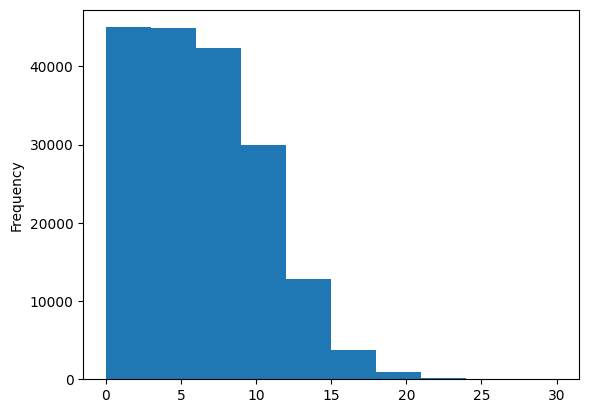

In [122]:
# Check the distribution of "line_number"
train_df.line_number.plot.hist()

In [123]:
np.percentile(train_df.line_number, 98)

15.0

In [124]:
# Use TensorFlow to create one-hot-encoded tensors of the "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [125]:
train_df.total_lines.value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

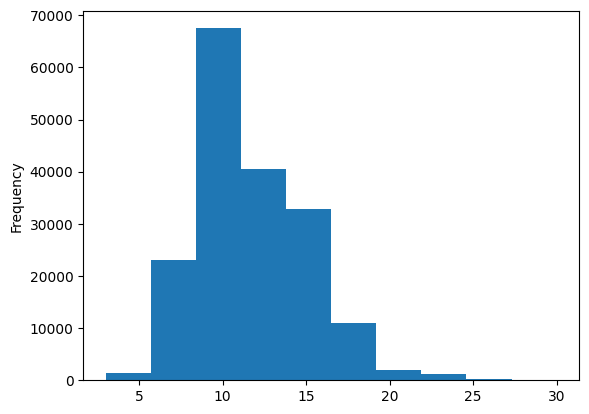

In [126]:
train_df.total_lines.plot.hist()

In [127]:
np.percentile(train_df.total_lines, 98)

20.0

In [128]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

In [129]:
train_total_lines_one_hot[0]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [130]:
# Building a tribrid embedding model
# Create a token-level model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embedding = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embedding)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# Create a character-level model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)


# Create a model for the "line_number" feature
ln_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
ln_outputs = layers.Dense(32, activation="relu")(ln_inputs)
ln_model = tf.keras.Model(inputs=ln_inputs,
                          outputs=ln_outputs)

# Create a model for the "total_lines" feature
tl_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
tl_outputs = layers.Dense(32, activation="relu")(tl_inputs)
tl_model = tf.keras.Model(inputs=tl_inputs,
                          outputs=tl_outputs)

# Combine the ouputs of token and character model
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
x = layers.Dense(256, activation="relu")(combined_embeddings)
x = layers.Dropout(0.5)(x)

# Combine the outputs of line_number, total_lines and both token and character models
tribrid_embeddings = layers.Concatenate(name="token_char_positional_embedding")([ln_model.output,
                                                                                tl_model.output,
                                                                                x])

# Create an output layer to accept the tribried embedding and output label probabilities
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# Combine the inputs of all models and outputs of the output layer
model_5 = tf.keras.Model(inputs=[ln_model.input,
                                 tl_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [131]:
plot_model(model_5, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [132]:
model_5.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

In [133]:
# Compile token, char and positional model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [134]:
train_ln_tl_token_char_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                  train_total_lines_one_hot,
                                                                  train_sentences,
                                                                  train_chars))

train_ln_tl_token_char_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_ln_tl_token_char_dataset = tf.data.Dataset.zip((train_ln_tl_token_char_data, train_ln_tl_token_char_labels))
train_ln_tl_token_char_dataset = train_ln_tl_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_ln_tl_token_char_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                  val_total_lines_one_hot,
                                                                  val_sentences,
                                                                  val_chars))

val_ln_tl_token_char_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_ln_tl_token_char_dataset = tf.data.Dataset.zip((val_ln_tl_token_char_data, val_ln_tl_token_char_labels))
val_ln_tl_token_char_dataset = val_ln_tl_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_ln_tl_token_char_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                                  test_total_lines_one_hot,
                                                                  test_sentences,
                                                                  test_chars))

test_ln_tl_token_char_labels = tf.data.Dataset.from_tensor_slices((test_labels_one_hot))
test_ln_tl_token_char_dataset = tf.data.Dataset.zip((test_ln_tl_token_char_data, test_ln_tl_token_char_labels))
test_ln_tl_token_char_dataset = test_ln_tl_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [135]:
train_ln_tl_token_char_dataset, val_ln_tl_token_char_dataset, test_ln_tl_token_char_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [137]:
# Callbacks
import datetime

SAVE_LOGS_DIR = "skimlit_20k_model_logs"
CHECKPOINT_DIR = "skimlit_20k_model_checkpoints/cp.ckpt"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=SAVE_LOGS_DIR + "/" + 'skimlit_20k_tribrid_model/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_DIR,
                                                         monitor="val_loss",
                                                         save_best_only=True,
                                                         save_weights_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                           patience=5)

reducelr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                         patience=3,
                                                         min_lr=1e-6,
                                                         factor=0.2)

In [139]:
model_5_history = model_5.fit(train_ln_tl_token_char_dataset,
                              validation_data=val_ln_tl_token_char_dataset,
                              steps_per_epoch=len(train_ln_tl_token_char_dataset),
                              validation_steps=len(val_ln_tl_token_char_dataset),
                              epochs=100,
                              callbacks=[tensorboard_callback,
                                         checkpoint_callback,
                                         early_stopping_callback,
                                         reducelr_callback])

Epoch 1/100
5627/5627 [==============================] - 677s 119ms/step - loss: 0.9520 - accuracy: 0.8243 - val_loss: 0.9088 - val_accuracy: 0.8483 - lr: 0.0010
Epoch 2/100
5627/5627 [==============================] - 652s 116ms/step - loss: 0.9083 - accuracy: 0.8546 - val_loss: 0.9022 - val_accuracy: 0.8523 - lr: 0.0010
Epoch 3/100
5627/5627 [==============================] - 689s 122ms/step - loss: 0.8961 - accuracy: 0.8634 - val_loss: 0.8985 - val_accuracy: 0.8527 - lr: 0.0010
Epoch 4/100
5627/5627 [==============================] - 646s 115ms/step - loss: 0.8873 - accuracy: 0.8698 - val_loss: 0.8967 - val_accuracy: 0.8563 - lr: 0.0010
Epoch 5/100
5627/5627 [==============================] - 584s 104ms/step - loss: 0.8807 - accuracy: 0.8753 - val_loss: 0.8953 - val_accuracy: 0.8564 - lr: 0.0010
Epoch 6/100
5627/5627 [==============================] - 571s 101ms/step - loss: 0.8748 - accuracy: 0.8791 - val_loss: 0.8976 - val_accuracy: 0.8552 - lr: 0.0010
Epoch 7/100
5627/5627 [=====

In [140]:
model_5.evaluate(val_ln_tl_token_char_dataset)

945/945 [==============================] - 40s 42ms/step - loss: 0.8936 - accuracy: 0.8595


[0.8936126232147217, 0.8594928979873657]

In [141]:
model_5_pred_probs = model_5.predict(val_ln_tl_token_char_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_results = model_evaluation_metrics(val_labels_encoded, model_5_preds)
model_5_results

{'Accuracy': 0.8594929167218324,
 'Precision': 0.8599206877188834,
 'Recall': 0.8594929167218324,
 'f1-score': 0.8572750274744105}

In [142]:
model_df = pd.DataFrame({"model_0": baseline_results,
                         "model_1": model_1_results,
                         "model_2": model_2_results,
                         "model_3": model_3_results,
                         "model_4": model_4_results,
                         "model_5": model_5_results})
model_df = model_df.T
model_df

,Accuracy,Precision,Recall,f1-score
model_0,0.721832,0.718647,0.721832,0.698925
model_1,0.788528,0.785934,0.788528,0.786467
model_2,0.713889,0.713708,0.713889,0.710812
model_3,0.662320,0.657786,0.662320,0.654261
model_4,0.737422,0.737499,0.737422,0.735241
model_5,0.859493,0.859921,0.859493,0.857275


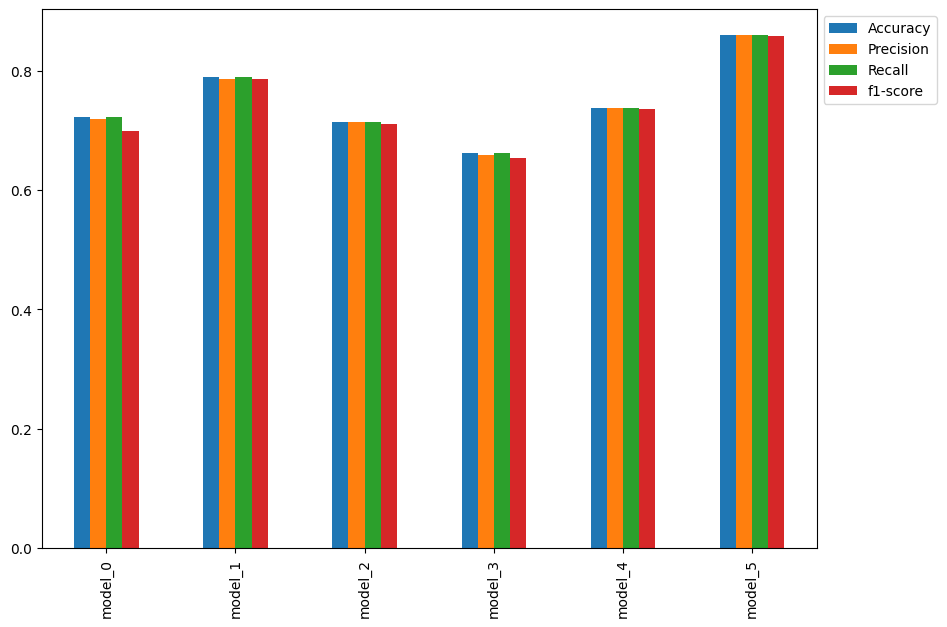

In [143]:
model_df.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

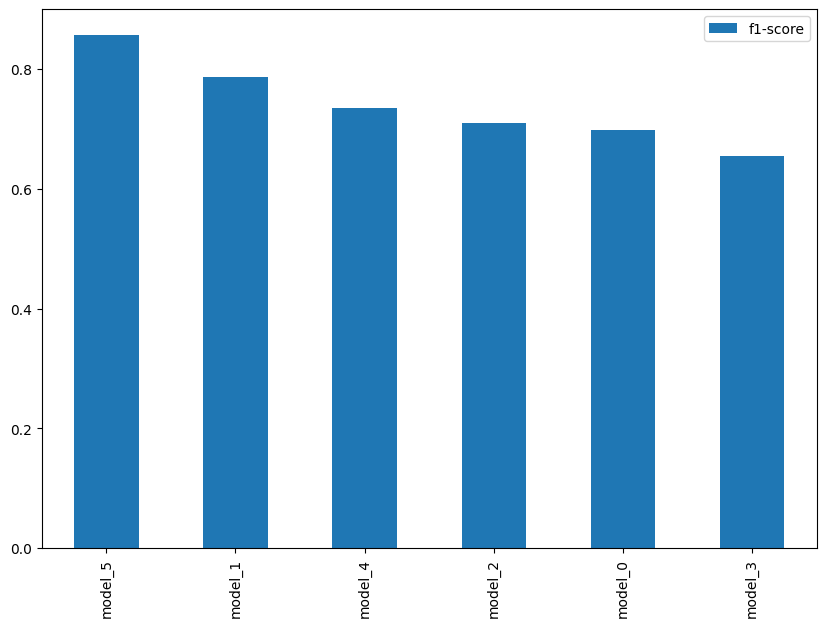

In [144]:
model_df.sort_values("f1-score", ascending=False)["f1-score"].plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

In [146]:
model_5.save("skimlit_20k_full_tribrid_model")

INFO:tensorflow:Assets written to: skimlit_20k_full_tribrid_model\assets


INFO:tensorflow:Assets written to: skimlit_20k_full_tribrid_model\assets


In [147]:
loaded_model = tf.keras.models.load_model("skimlit_20k_full_tribrid_model")

In [148]:
loaded_model_pred_probs = loaded_model.predict(val_ln_tl_token_char_dataset)
loaded_model_preds = tf.argmax(loaded_model_pred_probs, axis=1)
loaded_model_results = model_evaluation_metrics(val_labels_encoded, loaded_model_preds)
loaded_model_results

{'Accuracy': 0.8594929167218324,
 'Precision': 0.8599206877188834,
 'Recall': 0.8594929167218324,
 'f1-score': 0.8572750274744105}

In [149]:
model_5_results

{'Accuracy': 0.8594929167218324,
 'Precision': 0.8599206877188834,
 'Recall': 0.8594929167218324,
 'f1-score': 0.8572750274744105}

In [150]:
assert model_5_results == loaded_model_results

In [151]:
loaded_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

In [152]:
model_5_test_pred_probs = model_5.predict(test_ln_tl_token_char_dataset)
model_5_test_preds = tf.argmax(model_5_test_pred_probs, axis=1)
model_5_test_results = model_evaluation_metrics(test_labels_encoded, model_5_test_preds)
model_5_test_results

{'Accuracy': 0.8542890326862452,
 'Precision': 0.8540649643268157,
 'Recall': 0.8542890326862452,
 'f1-score': 0.8520345525810824}

In [153]:
# Finding the most wrong predictions
test_results_df = pd.DataFrame({"text": test_sentences,
                                "y_true": [class_names[i] for i in test_labels_encoded],
                                "y_preds": [class_names[i] for i in model_5_test_preds],
                                "pred_conf": tf.reduce_max(model_5_test_pred_probs).numpy()})

In [154]:
test_results_df[:10]

,text,y_true,y_preds,pred_conf
0,this study analyzed liver function abnormaliti...,BACKGROUND,BACKGROUND,0.992835
1,a post hoc analysis was conducted with the use...,RESULTS,METHODS,0.992835
2,liver function tests ( lfts ) were measured at...,RESULTS,METHODS,0.992835
3,survival analyses were used to assess the asso...,RESULTS,METHODS,0.992835
4,the percentage of patients with abnormal lfts ...,RESULTS,RESULTS,0.992835
5,when mean hemodynamic profiles were compared i...,RESULTS,RESULTS,0.992835
6,multivariable analyses revealed that patients ...,RESULTS,RESULTS,0.992835
7,abnormal lfts are common in the adhf populatio...,CONCLUSIONS,CONCLUSIONS,0.992835
8,elevated meld-xi scores are associated with po...,CONCLUSIONS,CONCLUSIONS,0.992835
9,minimally invasive endovascular aneurysm repai...,BACKGROUND,BACKGROUND,0.992835


In [155]:
test_results_df[test_results_df["y_true"] == test_results_df["y_preds"]].sort_values("pred_conf", ascending=False)

,text,y_true,y_preds,pred_conf
0,this study analyzed liver function abnormaliti...,BACKGROUND,BACKGROUND,0.992835
20142,to determine the effect of topical intranasal ...,OBJECTIVE,OBJECTIVE,0.992835
20152,@b .,METHODS,METHODS,0.992835
20151,oxymetazoline increased nasal airflow in patie...,CONCLUSIONS,CONCLUSIONS,0.992835
20150,there were no differences between groups in ox...,RESULTS,RESULTS,0.992835
...,...,...,...,...
10117,to test the hypothesis that lisa increases sur...,OBJECTIVE,OBJECTIVE,0.992835
10112,this can potentially lead to significant cost ...,CONCLUSIONS,CONCLUSIONS,0.992835
10111,the venner-pneux vap prevention system is asso...,CONCLUSIONS,CONCLUSIONS,0.992835
10110,a binary logistic regression analysis ( type o...,RESULTS,RESULTS,0.992835


In [156]:
most_wrong_test_results = test_results_df[test_results_df["y_true"] != test_results_df["y_preds"]].sort_values("pred_conf", ascending=False)

In [157]:
most_wrong_test_results[:10]

,text,y_true,y_preds,pred_conf
1,a post hoc analysis was conducted with the use...,RESULTS,METHODS,0.992835
19762,the objective was to determine the prevalence ...,BACKGROUND,OBJECTIVE,0.992835
19800,"from january @ to april @ , @ pregnant women a...",RESULTS,METHODS,0.992835
19786,"in conclusion , t replacement effects were fib...",CONCLUSIONS,RESULTS,0.992835
19768,its prevalence increased from @ % to @ % from ...,RESULTS,CONCLUSIONS,0.992835
19767,an was identified in any of the examined sites...,RESULTS,METHODS,0.992835
19765,overweight and obesity occurred in @ % and @ %...,METHODS,RESULTS,0.992835
19764,participants ' mean age was @ years .,METHODS,RESULTS,0.992835
19760,these studies were carried out at different ag...,BACKGROUND,METHODS,0.992835
19931,women with primary ovarian insufficiency ( poi...,OBJECTIVE,BACKGROUND,0.992835


In [158]:
def preprocess_raw_abstract(raw_abstract):
  sentences = [sentence.strip() for sentence in raw_abstract.split(".") if sentence.strip()]
  chars = [ " ".join(list(i)) for i in sentences]
  total_lines = len(sentences)-1
  line_numbers = [i for i, s in enumerate(sentences)]

  unseen_df = pd.DataFrame({"sentences": sentences,
                            "chars": chars,
                            "line_number": line_numbers,
                            "total_lines": total_lines})

  unseen_sent = unseen_df['sentences'].to_numpy()
  unseen_char = unseen_df['chars'].to_numpy()
  unseen_ln = tf.one_hot(unseen_df['line_number'].to_numpy(), depth=15)
  unseen_tl = tf.one_hot(unseen_df['total_lines'].to_numpy(), depth=20)

  unseen_data = [tf.constant(unseen_ln),
                 tf.constant(unseen_tl),
                 tf.constant(unseen_sent),
                 tf.constant(unseen_char)]

  return unseen_data, unseen_sent

In [177]:
preprocessed_unseen_data, sent = preprocess_raw_abstract("Breast cancer is one of the main leading causes of women death. In recent years, attention has been focused on the role of lipoproteins, alterations of cholesterol metabolism and oxidative stress in the molecular mechanism of breast cancer. A role for high density lipoproteins (HDL) has been proposed, in fact, in addition to the role of reverse cholesterol transport (RCT), HDL exert antioxidant and anti-inflammatory properties, modulate intracellular cholesterol homeostasis, signal transduction and proliferation. Low levels of HDL-Cholesterol (HDL-C) have been demonstrated in patients affected by breast cancer and it has been suggested that low levels of HDL-C could represent a risk factor of breast cancer. Contrasting results have been observed by other authors. Recent studies have demonstrated alterations of the activity of some enzymes associated to HDL surface such as Paraoxonase (PON1), Lecithin-Cholesterol Acyltransferase (LCAT) and Phospholipase A2 (PLA2). Higher levels of markers of lipid peroxidation in plasma or serum of patients have also been observed and suggest dysfunctional HDL in breast cancer patients. The review summarizes results on levels of markers of oxidative stress of plasma lipids and on alterations of enzymes associated to HDL in patients affected by breast cancer. The effects of normal and dysfunctional HDL on human breast cancer cells and molecular mechanisms potentially involved will be also reviewed.")

In [178]:
preprocessed_unseen_data

[<tf.Tensor: shape=(9, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 <tf.Tensor: shape=(9, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.

In [179]:
unseen_pred_probs = loaded_model.predict(preprocessed_unseen_data)
unseen_pred_probs

array([[0.6950217 , 0.09906686, 0.01965632, 0.13174196, 0.05451315],
       [0.72215617, 0.06539562, 0.02403124, 0.14821158, 0.04020541],
       [0.42178085, 0.15952796, 0.15246278, 0.1876481 , 0.07858032],
       [0.29930294, 0.3275503 , 0.15611114, 0.10577063, 0.111265  ],
       [0.07015271, 0.03132285, 0.18908788, 0.05291422, 0.65652233],
       [0.25763297, 0.12978446, 0.01374727, 0.0667043 , 0.53213096],
       [0.09063275, 0.61352634, 0.07304724, 0.05126586, 0.17152777],
       [0.0481337 , 0.33177593, 0.29226446, 0.04210274, 0.2857232 ],
       [0.07015462, 0.70546037, 0.11358342, 0.03921733, 0.0715843 ]],
      dtype=float32)

In [180]:
[class_names[tf.argmax(i, axis=0)] for i in unseen_pred_probs]

['BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'CONCLUSIONS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'CONCLUSIONS']

In [181]:
unseen_results_df = pd.DataFrame({"sentence": sent,
                                  "pred_class": [class_names[tf.argmax(i, axis=0)] for i in unseen_pred_probs]})

unseen_results_df

,sentence,pred_class
0,Breast cancer is one of the main leading cause...,BACKGROUND
1,"In recent years, attention has been focused on...",BACKGROUND
2,A role for high density lipoproteins (HDL) has...,BACKGROUND
3,Low levels of HDL-Cholesterol (HDL-C) have bee...,CONCLUSIONS
4,Contrasting results have been observed by othe...,RESULTS
5,Recent studies have demonstrated alterations o...,RESULTS
6,Higher levels of markers of lipid peroxidation...,CONCLUSIONS
7,The review summarizes results on levels of mar...,CONCLUSIONS
8,The effects of normal and dysfunctional HDL on...,CONCLUSIONS
